# Import Library

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from collections import Counter
from transformers import pipeline
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Load Data

In [8]:
df = pd.read_csv('/content/dataset_komentar_labeled_fix.csv')

In [9]:
df.head()

,author,text,likes,time,label
0,@ferryirwandi,Lekas pulih Bumi Andalasku!,4 rb,2 bulan yang lalu (diedit),2
1,@RahmatHidayat-r8d9h,Kejam banget para pemimpin 😢,1,3 minggu yang lalu,0
2,@komengkoclak7711,Memang sejak kapan pemerintah peduli pada masy...,1,3 minggu yang lalu,2
3,@Isnaratni,Karena dulu tdk memenangkan Prabowo jadi ndak ...,1,4 minggu yang lalu,1
4,@robysatriapratama311,Bg Fery bantu saya la BG. Kasih pekerjaan bg. ...,1,4 minggu yang lalu (diedit),0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   author  2500 non-null   object
 1   text    2500 non-null   object
 2   likes   2500 non-null   object
 3   time    2500 non-null   object
 4   label   2500 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 97.8+ KB


In [11]:
df.isnull().sum()

,0
author,0
text,0
likes,0
time,0
label,0


In [12]:
df.describe()

,label
count,2500.000000
mean,0.836400
std,0.633874
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,2.000000


# Data Preperation

## Feature Important

In [14]:
df_bert = df[['text', 'label']].rename(columns={'text': 'text'})

In [15]:
df_bert.head(10)

,text,label
0,Lekas pulih Bumi Andalasku!,2
1,Kejam banget para pemimpin 😢,0
2,Memang sejak kapan pemerintah peduli pada masy...,2
3,Karena dulu tdk memenangkan Prabowo jadi ndak ...,1
4,Bg Fery bantu saya la BG. Kasih pekerjaan bg. ...,0
5,Dek apakah president kita masi punya nurani da...,1
6,Bagaimana tanggapan abang tentang dampak negat...,1
7,"MEDAN MERDEKA COMENT FROM USA,,UURRRAAA",1
8,Banyak rakyat yang tidak suka juga ditetapkan ...,0
9,Semua bencana alam di Sumatera kesalahan pemer...,0


## Split Dataset

In [16]:
train_df, test_df = train_test_split(df_bert, test_size=0.2, random_state=42, stratify=df_bert['label'])

## Konversi ke format Hugging Face Dataset

In [17]:
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

In [18]:
print(f"Data latih: {len(train_dataset)} | Data uji: {len(test_dataset)}")

Data latih: 2000 | Data uji: 500


# Tokenisasi

In [19]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [20]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

In [21]:
# Jalankan tokenisasi pada seluruh dataset
train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

# Training Model

In [22]:
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', num_labels=3)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: indobenchmark/indobert-base-p2
Key               | Status  | 
------------------+---------+-
classifier.weight | MISSING | 
classifier.bias   | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [26]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",     # Strategi evaluasi diubah ke 'epoch'
    save_strategy="epoch",     # Strategi simpan juga diubah ke 'epoch' (Harus sama!)
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,  # Sekarang ini akan bekerja karena sudah ada data evaluasi setiap epoch
    logging_dir='./logs',
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [27]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
)

In [28]:
# Mulai proses training (Gunakan GPU agar cepat)
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.558625
2,No log,0.530320
3,No log,0.584621


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=375, training_loss=0.45504642740885415, metrics={'train_runtime': 317.4694, 'train_samples_per_second': 18.899, 'train_steps_per_second': 1.181, 'total_flos': 394670126592000.0, 'train_loss': 0.45504642740885415, 'epoch': 3.0})

# Evaluasi

In [29]:
raw_pred, _, _ = trainer.predict(test_tokenized)
y_pred = np.argmax(raw_pred, axis=1)
y_true = test_df['label'].values

In [32]:
print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.81      0.81      0.81       148
     Neutral       0.83      0.85      0.84       286
    Positive       0.63      0.56      0.59        66

    accuracy                           0.80       500
   macro avg       0.75      0.74      0.75       500
weighted avg       0.80      0.80      0.80       500



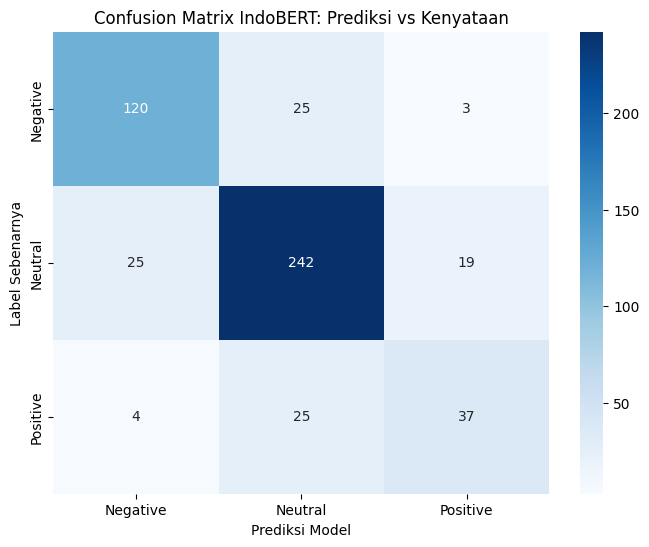

In [33]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix IndoBERT: Prediksi vs Kenyataan')
plt.ylabel('Label Sebenarnya')
plt.xlabel('Prediksi Model')
plt.show()

# Save Model

In [34]:
# Simpan model dan tokenizer ke folder lokal di Colab
model.save_pretrained("./my_indobert_model")
tokenizer.save_pretrained("./my_indobert_model")
print("Model berhasil disimpan!")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model berhasil disimpan!


# Fungsi Prediksi (Production Ready)

In [39]:
load_path = "./my_indobert_model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_tokenizer = BertTokenizer.from_pretrained(load_path)
my_model = BertForSequenceClassification.from_pretrained(load_path).to(device)

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

In [40]:
def klasifikasi_komentar(teks):
    # Pembersihan dasar (Opsional, gunakan fungsi clean_text yang kita buat sebelumnya)
    # teks = clean_text(teks)

    # Tokenisasi
    inputs = my_tokenizer(teks, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    # Prediksi
    with torch.no_grad():
        outputs = my_model(**inputs)
        logits = outputs.logits

    # Ambil skor probabilitas tertinggi
    probs = torch.nn.functional.softmax(logits, dim=-1)
    prediction = torch.argmax(probs, dim=-1).item()

    # Mapping angka kembali ke label
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return label_map[prediction]

# Testing

In [41]:
input_user = "Pemerintah harusnya lebih tanggap, kasihan warga Sumatera!"
hasil = klasifikasi_komentar(input_user)
print(f"Komentar: {input_user} \nKategori: {hasil}")

Komentar: Pemerintah harusnya lebih tanggap, kasihan warga Sumatera! 
Kategori: Positive


In [42]:
input_user = "Semoga Lekas Sembuh sumateraku"
hasil = klasifikasi_komentar(input_user)
print(f"Komentar: {input_user} \nKategori: {hasil}")

Komentar: Semoga Lekas Sembuh sumateraku 
Kategori: Neutral


In [43]:
input_user = "pemerintah tidak peduli sumatera"
hasil = klasifikasi_komentar(input_user)
print(f"Komentar: {input_user} \nKategori: {hasil}")

Komentar: pemerintah tidak peduli sumatera 
Kategori: Negative
